# Calculating RNBS
Lindsay Fitzpatrick
ljob@umich.edu
08/19/2024

This script uses the forecast data from CFS and runs it through the trained models to produce
an ensemble of RNBS forecasts for each of the Great Lakes. It saves the forecast values as a 
CSV and creates a timeseries plot that is saved as a PNG.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import joblib
import calendar

User Input

In [2]:
# Directory to downloaded/processed CFS data
dir = f'C:/Users/fitzpatrick/Desktop/Data/'
dir = '/Users/dannes/Documents/NBS-Predictor-MVP-Dev/NBS-Predictor-MVP-test/Data/'

# Read in the CSVs
pcp_data = pd.read_csv(dir+f'CFS_PCP_forecasts_Sums_CMS.csv',sep=',')
tmp_data = pd.read_csv(dir+f'CFS_TMP_forecasts_Avgs_K.csv',sep=',')
evap_data = pd.read_csv(dir+f'CFS_EVAP_forecasts_Sums_CMS.csv',sep=',')

# Open the trained model(s)
# For the MVP we are only going to use the GP model since it has the best performance
GP_model = joblib.load('GP_trained_model.joblib')

c:\Users\fitzpatrick\AppData\Local\miniconda3\envs\mvpenv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GaussianProcessRegressor from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Read in the precip, evap, and air temp forecasts from the CFS forecast. We add the totals for Mich and 
Huron together with the exception of air temp where we take the average of the two lakes. We put them all
into a new dataframe 'X' which will be our features to run through the models.

In [3]:
X = pd.DataFrame({
    'su_pcp': pcp_data['sup_lake'],
    'er_pcp': pcp_data['eri_lake'],
    'on_pcp': pcp_data['ont_lake'],
    'mh_pcp': pcp_data['mic_lake']+pcp_data['hur_lake'],
    'su_evap': evap_data['sup_lake'],
    'er_evap': evap_data['eri_lake'],
    'on_evap': evap_data['ont_lake'],
    'mh_evap': evap_data['mic_lake']+evap_data['hur_lake'],
    'su_tmp': tmp_data['sup_lake'],
    'er_tmp': tmp_data['eri_lake'],
    'on_tmp': tmp_data['ont_lake'],
    'mh_tmp': (tmp_data['mic_lake']+tmp_data['hur_lake'])/2
})
print(X)

           su_pcp      er_pcp      on_pcp       mh_pcp      su_evap  \
0      636.369837  300.622778   63.822853  2466.485814   902.196763   
1     2744.115733  375.388680  181.523281  2534.983177  1634.307881   
2     2605.488977  540.368897  271.529871  5117.100000  1859.368565   
3     2062.170153  677.219713  298.480950  2658.118961  1596.361713   
4     1852.993242  532.976397  292.464141  2550.001095  2662.666146   
...           ...         ...         ...          ...          ...   
1652  1819.704887  220.648784  124.018278  1898.963731  2231.944950   
1653  2147.244782  488.056176  252.052768  2548.175888  1623.688688   
1654  1009.261401  831.451059  407.920721  4053.483334   908.114640   
1655  1052.402441  476.829679  226.677355  2130.220673   332.067561   
1656  2372.512870  328.671750  256.712089  2006.727180   304.199602   

         er_evap     on_evap      mh_evap      su_tmp      er_tmp      on_tmp  \
0     591.158547  318.590900  2998.510730  289.981428  293.224596 

Standardize the data

In [4]:
# Standardize the data
x_scaler = joblib.load('x_scaler.joblib')
y_scaler = joblib.load('y_scaler.joblib')
X_scaled = x_scaler.transform(X)

c:\Users\fitzpatrick\AppData\Local\miniconda3\envs\mvpenv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Run the scaled data through the trained GP model. Put the results into a new dataframe. Add the month
as a column in the dataframe. Then save the RNBS forecast to a CSV. 

In [5]:
# Predict RNBS using GP
y_pred_scaled = GP_model.predict(X_scaled)

y_pred = y_scaler.inverse_transform(y_pred_scaled) # unscale the predictions
df_y_pred = pd.DataFrame(y_pred, columns=['sup', 'eri', 'ont', 'mih'])
print(df_y_pred)

              sup          eri          ont          mih
0      467.026340  -841.438989  -226.324481  1038.217793
1     1292.960433  -916.784246  -179.906668 -1141.040633
2      201.678581   -74.625984   656.816027  4887.484579
3      416.570657  1107.901611  1132.367995  1924.663848
4    -1136.610247   611.669284  1206.706296  1149.007902
...           ...          ...          ...          ...
1652   -33.844695   153.793893   611.247127  1675.429971
1653   517.587836  1371.900685  1512.869105  3282.815950
1654   226.553434  2430.070577  2250.229050  6575.541416
1655  1140.965300   637.069566   854.970039  1749.326489
1656  3059.615796  -209.358909   612.611395   536.799700

[1657 rows x 4 columns]


In [13]:
df_y_pred['month'] = pcp_data['forecast_month'].astype(int)
df_y_pred['year'] = pcp_data['forecast_year'].astype(int)



Before plotting, we can remove any forecasts that are from previous months that have passed and only look at the future months forecasts.

In [ ]:
current_month = datetime.now().month
current_year = datetime.now().year

filtered_y_pred = df_y_pred[
    (df_y_pred['year'] > current_year) |
    ((df_y_pred['year'] == current_year) & (df_y_pred['month'] >= current_month))
]
filtered_y_pred.to_csv(dir+f'RNBS_forecasts.csv',sep=',',index=False)

print(filtered_y_pred)

              sup          eri          ont          mih  month  year
1     1292.960433  -916.784246  -179.906668 -1141.040633      9  2024
2      201.678581   -74.625984   656.816027  4887.484579     10  2024
3      416.570657  1107.901611  1132.367995  1924.663848     11  2024
4    -1136.610247   611.669284  1206.706296  1149.007902     12  2024
5     -991.713736   434.748916   807.793511   954.783250      1  2025
...           ...          ...          ...          ...    ...   ...
1652   -33.844695   153.793893   611.247127  1675.429971      2  2025
1653   517.587836  1371.900685  1512.869105  3282.815950      3  2025
1654   226.553434  2430.070577  2250.229050  6575.541416      4  2025
1655  1140.965300   637.069566   854.970039  1749.326489      5  2025
1656  3059.615796  -209.358909   612.611395   536.799700      6  2025

[1536 rows x 6 columns]


In [15]:
def mean_min_max(df,lake):
    mean = df.groupby(['year', 'month'])[lake].mean().reset_index()
    min = df.groupby(['year', 'month'])[lake].min().reset_index()
    max = df.groupby(['year', 'month'])[lake].max().reset_index()

    return mean, min, max

mean_su, min_su, max_su = mean_min_max(filtered_y_pred,'sup')
mean_er, min_er, max_er = mean_min_max(filtered_y_pred,'eri')
mean_on, min_on, max_on = mean_min_max(filtered_y_pred,'ont')
mean_mh, min_mh, max_mh = mean_min_max(filtered_y_pred,'mih')


C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_21196\2281142275.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels([calendar.month_abbr[df_y_pred['month'][0]], calendar.month_abbr[df_y_pred['month'][1]],


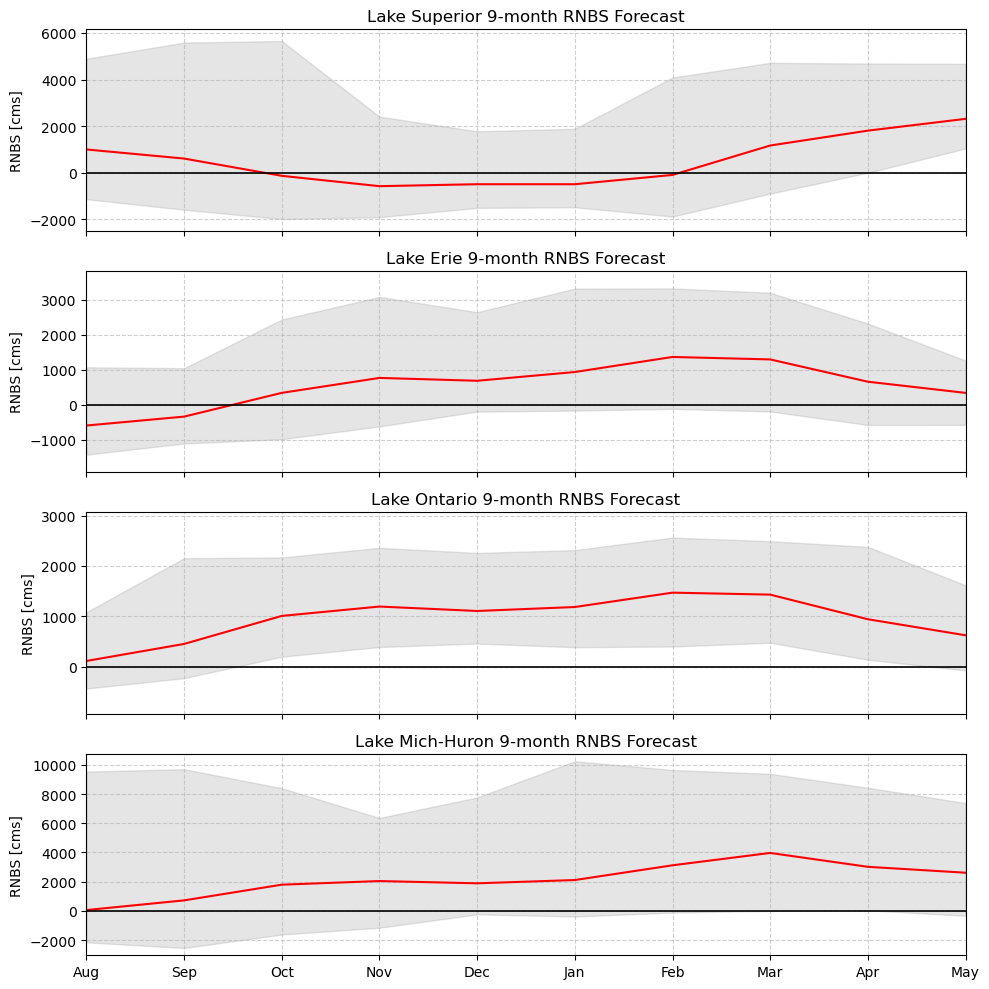

In [17]:
def plot_rnbs_forecast(x_values, data_dict):
    """
    Plots RNBS forecasts for different lakes.

    Parameters:
    - x_values: array-like, the x-axis values (e.g., months)
    - data_dict: dictionary containing data for each lake. The keys are lake names, and the values are tuples containing
                 (mean, min, max) for that lake.

    The dictionary should be formatted as:
    {
        'Lake Superior': (mean_su, min_su, max_su),
        'Lake Erie': (mean_er, min_er, max_er),
        'Lake Ontario': (mean_on, min_on, max_on),
        'Lake Mich-Huron': (mean_mh, min_mh, max_mh)
    }
    """
    # Create a 4x1 grid of subplots
    fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
    
    # Titles for the subplots
    titles = [
        'Lake Superior 9-month RNBS Forecast',
        'Lake Erie 9-month RNBS Forecast',
        'Lake Ontario 9-month RNBS Forecast',
        'Lake Mich-Huron 9-month RNBS Forecast'
    ]
    
    # Plot each dataset
    for i, (lake_name, (mean, min_val, max_val)) in enumerate(data_dict.items()):
        # Ensure min_val and max_val are scalars

        axs[i].plot(x_values, mean, color='red', linestyle='-', linewidth=1.5, label='Mean')
        axs[i].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
        axs[i].fill_between(x_values, min_val, max_val, color='gray', alpha=0.2)
        axs[i].set_ylabel('RNBS [cms]')
        axs[i].set_title(titles[i])
        axs[i].set_xlim(0, 9)  # Setting x-axis limits from 1 to 10
        axs[i].set_ylim(min_val.min()-500, max_val.max()+500)
        axs[i].grid(True, linestyle='--', alpha=0.6)
        
        if i == 3:  # Set labels for the last subplot
            axs[i].set_xticklabels([calendar.month_abbr[df_y_pred['month'][0]], calendar.month_abbr[df_y_pred['month'][1]],
                                    calendar.month_abbr[df_y_pred['month'][2]], calendar.month_abbr[df_y_pred['month'][3]],
                                    calendar.month_abbr[df_y_pred['month'][4]], calendar.month_abbr[df_y_pred['month'][5]],
                                    calendar.month_abbr[df_y_pred['month'][6]], calendar.month_abbr[df_y_pred['month'][7]],
                                    calendar.month_abbr[df_y_pred['month'][8]], calendar.month_abbr[df_y_pred['month'][9]]])
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig(dir+f'RNBS_forecasts.png', bbox_inches='tight')
    plt.show()

# Example usage
x_values = np.arange(len(mean_su['sup']))  # x-axis values
data_dict = {
    'Lake Superior': (mean_su['sup'], min_su['sup'], max_su['sup']),
    'Lake Erie': (mean_er['eri'], min_er['eri'], max_er['eri']),
    'Lake Ontario': (mean_on['ont'], min_on['ont'], max_on['ont']),
    'Lake Mich-Huron': (mean_mh['mih'], min_mh['mih'], max_mh['mih'])
}

plot_rnbs_forecast(x_values, data_dict)